y_range: tensor(-0.0142) tensor(0.3178)
y1_range: tensor(-0.0418) tensor(0.3206)
tensor(-0.0012) tensor(0.0087)
tensor(-0.0762) tensor(1.0477)


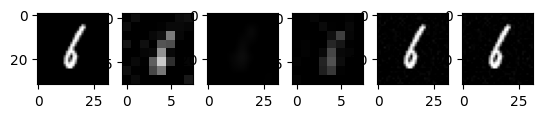

In [72]:
import numpy as np
from PIL import Image
import torch
betas = np.linspace(1e-4, 0.02, 1000)
alphas = 1 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alp = alphas_cumprod[9]
x = np.array(Image.open('/users/js3006/conddiff/UD2M/guided-diffusion-edit/data/mnist_images/6_45614.png').convert('L')).astype(np.float32) / 255.0
x = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)
xt = np.sqrt(alp) * x + np.sqrt(1-alp) * torch.randn_like(x)
from deepinv.physics import Downsampling, GaussianNoise, BlurFFT
sigma=0.05
from deepinv.physics.blur import gaussian_blur
physic = Downsampling(img_size = (1,32,32), filter='bicubic',factor=4, noise_model=GaussianNoise(sigma=sigma))
# physic = BlurFFT((1,32,32), filter=gaussian_blur(sigma=(3,3)), noise_model=GaussianNoise(sigma=sigma))
y = physic(x)
y_up = physic.A_adjoint(y).clamp(0,1)

from deepinv.physics import LinearPhysics, DecomposablePhysics
from deepinv.utils.tensorlist import TensorList
class DiffJointPhysics(LinearPhysics):
    def __init__(self, physics):
        super().__init__()
        self.physics = physics
        self.alpha = torch.tensor(alp).float().view(1,1,1,1)

    def _set_alp(self, alp):
        self.alpha = torch.tensor(alp).float().view(1,1,1,1)
    
    def A(self, x):
        y = self.physics.A(x)*self.sigma_min/self.physics.noise_model.sigma
        print("y_range:", y.min(), y.max())
        xt = self.alpha.sqrt() * x * 2*self.sigma_min/((1-self.alpha).sqrt())
        return TensorList([y, xt])
    
    def A_adjoint(self, y):
        y1, y2 = y[0], y[1]
        print("y1_range:", y1.min(), y1.max())
        x1 = self.physics.A_adjoint(y1)*self.sigma_min/self.physics.noise_model.sigma
        print(x1.min(), x1.max())
        x2 = self.alpha.sqrt() * y2 * 2*self.sigma_min/((1-self.alpha).sqrt())
        return x1 + x2
    
    def forward(self, x, alpha = None):
        if alpha is not None:
            self._set_alp(alpha)
        sigma_min = torch.min(torch.tensor([self.physics.noise_model.sigma, (1-self.alpha).sqrt()/2]))
        self.sigma_min = sigma_min
        out = self.A(x)
        out = out + self.sigma_min * TensorList([torch.randn_like(out[0]), torch.randn_like(out[1])])
        return out
class DecDiffJointPhysics(DecomposablePhysics):
    def __init__(self, physics):
        super().__init__()
        self.physics = physics
        self.alpha = torch.tensor(alp).float().view(1,1,1,1)

    def _set_alp(self, alp):
        self.alpha = torch.tensor(alp).float().view(1,1,1,1)
    
    def A(self, x):
        y = self.physics.A(x)*self.sigma_min/self.physics.noise_model.sigma
        
        xt = self.alpha.sqrt() * x * 2*self.sigma_min/((1-self.alpha).sqrt())
        return TensorList([y, xt])
    
    def A_adjoint(self, y):
        y1, y2 = y[0], y[1]
        x1 = self.physics.A_adjoint(y1)*self.sigma_min/self.physics.noise_model.sigma
        x2 = self.alpha.sqrt() * y2 * 2*self.sigma_min/((1-self.alpha).sqrt())
        return x1 + x2
    
    def forward(self, x, alpha = None):
        if alpha is not None:
            self._set_alp(alpha)
        sigma_min = torch.min(torch.tensor([self.physics.noise_model.sigma, (1-self.alpha).sqrt()/2]))
        self.sigma_min = sigma_min
        out = self.A(x)
        out = out + self.sigma_min * TensorList([torch.randn_like(out[0]), torch.randn_like(out[1])])
        return out
    
    def A_dagger(self, y, mask=None, **kwargs):
        msk = (self.physics.mask*self.physics.mask*self.sigma_min**2/self.physics.noise_model.sigma**2 + self.alpha*4*self.sigma_min**2/((1-self.alpha)))
        msk[msk<1e-2] = 1e-2
        aty = self.A_adjoint(y)
        return self.physics.V(self.physics.V_adjoint(aty)/msk)
    
jointphysics = DiffJointPhysics(physic)
y_joint = jointphysics(x, alpha=alp)
y_joint_up = jointphysics.A_adjoint(y_joint)
print(y_joint_up.min(), y_joint_up.max())
import matplotlib.pyplot as plt
plt.subplot(1,6,1)
plt.imshow(x.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,6,2)
plt.imshow(y.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,6,3)
plt.imshow(y_up.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,6,4)
plt.imshow(y_joint[0].squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,6,5)
plt.imshow(y_joint[1].squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,6,6)
plt.imshow(y_joint_up.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()

In [ ]:
import numpy as np 
x = np.load("/users/js3006/MNISTDiff/guided-diffusion/logs/2025-10-02_16-29-24/samples_16x32x32x1.npz")
print(x["arr_0"].shape)

# Plot results
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow((x["arr_0"][i] * 255).astype(np.uint8))
    ax.axis('off')
plt.tight_layout()
plt.show()